<a href="https://colab.research.google.com/github/VLCHS/FCNN-for-p_pi0/blob/FCNN/Training_FCNN_p_pi0%26results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Getting Started

In [1]:
!pip install --q wandb
!pip install --q wandb[media]
!pip install --q torch==2.5.1
!pip install --q lightning==2.4.0
!pip install --q featuretools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# necessary code, if wandb doesn't want to login for no reason
import os
os.environ['WANDB_INIT_TIMEOUT'] = '300'
os.environ['WANDB_HTTP_TIMEOUT'] = '300'
os.environ["WANDB__SERVICE_WAIT"] = "300"
os.environ['WANDB_DEBUG'] = 'true'
os.environ['WANDB_CORE_DEBUG'] = 'true'

In [3]:
import os
import sys

import tqdm
import math
import wandb
wandb.require("legacy-service")

import torch
import pylab
import random
import logging
import torchmetrics

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import featuretools as ft

from scipy import spatial
from random import randint
from scipy.stats import chisquare, kstest
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError
from torchmetrics import MeanSquaredError
from torchmetrics import R2Score
from sklearn.metrics import root_mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    pl.seed_everything(seed)

set_random_seed(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [4]:
device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [5]:
from google.colab import files
uploaded = files.upload()

Saving clasdb_pi_0_p.txt to clasdb_pi_0_p.txt


In [6]:
# Load the data Ebeam = [1.64 2.44 5.75 2.04]
df = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df['cos_phi'] = df['phi'].apply(lambda x: math.cos(x))
df['sin_phi'] = df['phi'].apply(lambda x: math.sin(x))
df['Ebeam'] = df['Ebeam'].round(decimals=2)
df = df.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
df = df[df['dsigma_dOmega'] <= df["dsigma_dOmega"].quantile(0.97)]
df = df[df['error'] <= df["error"].quantile(0.98)]
df = df.drop(df[df['dsigma_dOmega'] == 0].index)
df = df.drop('id', axis=1)
df = df.reset_index(drop=True)
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
df = df.reset_index(drop=True)
df

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,cos_phi,sin_phi
0,1.64,1.1000,0.40,-0.9,0.261799,0.912000,0.982353,0.965926,0.258819
1,1.64,1.1000,0.40,-0.9,0.785398,0.175000,0.356108,0.707107,0.707107
2,1.64,1.1000,0.40,-0.9,1.308997,1.650000,2.769879,0.258819,0.965926
3,1.64,1.1000,0.40,-0.9,1.832596,0.560000,0.979330,-0.258819,0.965926
4,1.64,1.1000,0.40,-0.9,2.356194,1.130000,0.909689,-0.707107,0.707107
...,...,...,...,...,...,...,...,...,...
72238,2.04,1.7875,0.65,0.9,4.581489,0.485355,0.093559,-0.130526,-0.991445
72239,2.04,1.7875,0.65,0.9,4.843289,0.528385,0.083915,0.130526,-0.991445
72240,2.04,1.7875,0.65,0.9,5.105088,0.497479,0.107885,0.382683,-0.923880
72241,2.04,1.7875,0.65,0.9,5.366887,2.774690,2.426200,0.608761,-0.793353


Text(0, 0.5, 'Q^2, GeV^2')

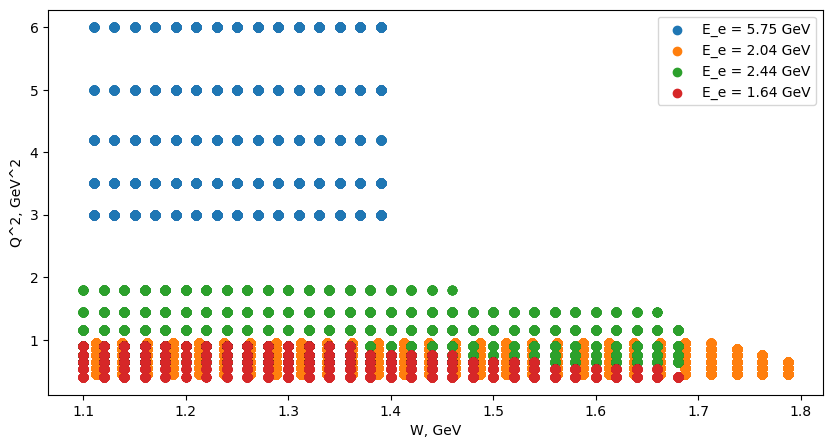

In [7]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(df[df.Ebeam==5.75].W, df[df.Ebeam==5.75].Q2, label='E_e = 5.75 GeV')
plt.scatter(df[df.Ebeam==2.04].W, df[df.Ebeam==2.04].Q2, label='E_e = 2.04 GeV')
plt.scatter(df[df.Ebeam==2.44].W, df[df.Ebeam==2.44].Q2, label='E_e = 2.44 GeV')
plt.scatter(df[df.Ebeam==1.64].W, df[df.Ebeam==1.64].Q2, label='E_e = 1.64 GeV')
plt.legend()
plt.xlabel('W, GeV')
plt.ylabel('Q^2, GeV^2')

#TRAINING

In [14]:
# Initialize wandb
wandb.init(entity='nucl_clas', project="FCNN for ep->ep_pi0, unified topology", name="8.3 Optimizer: NAdam")

In [15]:
#params
project_name = "FCNN for ep->ep_pi0, unified topology"

logger_path = './wandb_local_logs'
data_path = '/content/clasdb_pi_0_p.txt'

hyperparams_dict = {
    'feature_engineering': False,
    'scale_data': True,
    'feature_scaler': StandardScaler(),
    'label_scaler': MinMaxScaler(),
    'augment': False,
    'augment_factor': 5,
    'test_size': 0.1,
    'batch_size': 256,
    'net_architecture': [6,60,80,100,120,140,240,340,440,640,2000,1040,640,340,
                         240,140,100,80,60,20,1],  #the 1st layer is 6 or 37
    'activation_function': nn.ReLU(), #nn.LeakyReLU(0.01),
    'loss_func': nn.L1Loss(),
    'optim_func': torch.optim.NAdam,
    'max_epochs': 200,
    'es_min_delta': 1e-05,
    'es_patience': 30,
    'lr': 0.001,
    'lr_factor': 0.5,
    'lr_patience': 5,
    'lr_cooldown': 20,
}

wandb_logger = WandbLogger(project=project_name,
                           save_dir=logger_path)
exp_name = wandb_logger.experiment.name

logger_full_path = os.path.join(logger_path, project_name, exp_name)

os.makedirs(logger_full_path, exist_ok=True)
logging.basicConfig(encoding='utf-8',
                    level=logging.DEBUG,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                              logging.StreamHandler(sys.stdout)],
                    force=True)

class InterpolDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len

class InterpolDataModule(pl.LightningDataModule):
    def __init__(self, hyperparams):
        super().__init__()
        self.df = None
        self.hyperparams = hyperparams
        self.train_dataset = None
        self.val_dataset = None

    def augment(self, new_augm):
        augm_phi = np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi/30), 0, 2*np.pi)
        augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam/30),
                           'W': np.random.normal(loc=new_augm.W, scale=new_augm.W/30),
                           'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2/30),
                           'cos_theta': np.clip(np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta/30)), -1, 1),
                           'phi': augm_phi,
                           'cos_phi': math.cos(augm_phi),
                           'sin_phi': math.sin(augm_phi),
                           'dsigma_dOmega': np.random.normal(loc=new_augm.dsigma_dOmega, scale=new_augm.error/3),
                           'error': new_augm.error,
                           #'reaction_type': new_augm.reaction_type,
                          })
        return augm

    def feature_engineering(self, df):
        df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
        es = ft.EntitySet(id="data")
        es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

        # Run deep feature synthesis with transformation primitives
        feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                              trans_primitives = ['add_numeric', 'multiply_numeric'])

        df_after_feature_eng = feature_matrix.copy()
        #df_after_feature_eng['reaction_type'] = df['reaction_type']
        return df_after_feature_eng


    #DATA READING AND PREPROCESSING
    def setup(self, stage):
        # df for ep->ep_pi0, reaction_type=1
        # Ebeam = [1.64 2.44 5.75 2.04]
        df_p = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
        df_p.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        df_p['phi'] = df_p.phi.apply(lambda x: math.radians(x))
        df_p['cos_phi'] = df_p['phi'].apply(lambda x: math.cos(x))
        df_p['sin_phi'] = df_p['phi'].apply(lambda x: math.sin(x))
        df_p['Ebeam'] = df_p['Ebeam'].round(decimals=2)                              #PREPROCESSING
        df_p = df_p.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})                     #PREPROCESSING
        #df_p = df_p[df_p['dsigma_dOmega'] <= df_p["dsigma_dOmega"].quantile(0.97)]   #PREPROCESSING
        #df_p = df_p[df_p['error'] <= df_p["error"].quantile(0.98)]                   #PREPROCESSING
        df_p = df_p.drop(df_p[df_p['dsigma_dOmega'] == 0].index)                     #PREPROCESSING
        #df_p["reaction_type"] = 1
        df_p = df_p.drop('id', axis=1)
        df_p = df_p.reset_index(drop=True)
        df_p = df_p.iloc[df_p[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        df_p = df_p.reset_index(drop=True)
        df = df_p.copy()

        # # df for ep->en_pi+, reaction_type=0
        # df_n = pd.read_csv('/content/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
        # df_n.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        # df_n.loc[8314:65670, 'Ebeam'] = 5.754 # peculiarity of this dataset.
        # df_n['phi'] = df_n.phi.apply(lambda x: math.radians(x))
        # df_n['cos_phi'] = df_n['phi'].apply(lambda x: math.cos(x))
        # df_n['sin_phi'] = df_n['phi'].apply(lambda x: math.sin(x))
        # df_n = df_n[df_n['dsigma_dOmega'] <= df_n["dsigma_dOmega"].quantile(0.97)]
        # df_n = df_n[df_n['error'] <= df_n["error"].quantile(0.98)]
        # df_n = df_n.drop('id', axis=1)
        # df_n = df_n.reset_index(drop=True)
        # df_n = df_n.iloc[df_n[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        # df_n["reaction_type"] = 0
        # df_n = df_n.reset_index(drop=True)

        # # concat df_p and df_n into df
        # df = pd.concat([df_p, df_n], ignore_index=True)
        self.df = df

        feature_columns = list(df.columns)
        feature_columns.remove('dsigma_dOmega')
        feature_data = df[feature_columns]
        label_data = df['dsigma_dOmega']


        #TRAIN TEST SPLIT
        train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                  label_data,
                                                                                                  test_size=self.hyperparams.get('test_size'),
                                                                                                  random_state=42)


        # AUGMENTATION ON TRAIN DATA
        if self.hyperparams.get('augment'):
            train_df = pd.concat([train_feature_data, train_label_data], axis=1)
            aug_series_list = []
            for i in tqdm.tqdm(train_df.itertuples()):
                for _ in range(self.hyperparams.get('augment_factor')):
                    aug_series_list.append(self.augment(i))

            aug_df = pd.DataFrame(aug_series_list)
            augment_train_df = pd.concat([train_df, aug_df], ignore_index=True)
            train_label_data = augment_train_df["dsigma_dOmega"]
            train_feature_data = augment_train_df.loc[:, ~augment_train_df.columns.isin(["dsigma_dOmega"])]
        else:
            pass

        # DELETING PHI AND ERROR FROM FEATURES
        train_feature_data = train_feature_data.reset_index(drop=True)
        val_feature_data = val_feature_data.reset_index(drop=True)
        train_feature_data = train_feature_data.loc[:, ~train_feature_data.columns.isin(["phi", "error"])]
        val_feature_data = val_feature_data.loc[:, ~val_feature_data.columns.isin(["phi", "error"])]


        # FEATURE ENGINEERING
        if self.hyperparams.get('feature_engineering'):
            train_feature_data = self.feature_engineering(train_feature_data)
            val_feature_data = self.feature_engineering(val_feature_data)
        else:
            pass


        # SCALE DATA (FIT_TRANSFORM TRAIN AND TRANSFORM VAL)
        # DON'T SCALE REACTION_TYPE IN FEATURE DATASETS
        if self.hyperparams.get('scale_data'):
            #scale feature_data
            scaler_feature = self.hyperparams.get('feature_scaler')
            train_feature_data = train_feature_data.reset_index(drop=True)
            val_feature_data = val_feature_data.reset_index(drop=True)

            columns_to_scale = list(train_feature_data.columns)
            #columns_to_scale.remove("reaction_type")
            train_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.fit_transform(train_feature_data[columns_to_scale]))
            val_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.transform(val_feature_data[columns_to_scale]))

            #scale label_data
            scaler_target = self.hyperparams.get('label_scaler')
            train_label_data = pd.Series(scaler_target.fit_transform(train_label_data.to_frame())[:,0])
            val_label_data = pd.Series(scaler_target.transform(val_label_data.to_frame())[:,0])
        else:
            pass


        self.train_dataset = InterpolDataSet(torch.tensor(train_feature_data.values, dtype=torch.float32),
                                             torch.tensor(train_label_data.values, dtype=torch.float32))

        self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data.values, dtype=torch.float32),
                                           torch.tensor(val_label_data.values, dtype=torch.float32))


    def train_dataloader(self):
        return DataLoader(dataset = self.train_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(dataset = self.val_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=0)



class PrintCallbacks(Callback):
    def on_train_start(self, trainer, pl_module):
        logging.info("Training is starting")

    def on_train_end(self, trainer, pl_module):
        logging.info("Training is ending")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
        pl_module.training_step_outputs.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
        pl_module.validation_step_outputs.clear()

class InterpolRegressor(pl.LightningModule):
    def __init__(self, hyperparams):
        super(InterpolRegressor, self).__init__()

        self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0,0,0,0
        self.train_mse, self.val_mse = 0,0
        self.train_rmse, self.val_rmse = 0,0
        self.train_r2, self.val_r2 = 0,0
        self.hyperparams = hyperparams
        self.save_hyperparameters(self.hyperparams)

        self.mae = MeanAbsoluteError()
        self.mse = MeanSquaredError()
        self.rmse = self.mse ** 0.5
        self.r2 = R2Score()
        self.loss_func = self.hyperparams.get('loss_func')

        self.optim = self.hyperparams.get('optim_func')

        self.net_architecture = self.hyperparams.get('net_architecture')
        self.activation_function = self.hyperparams.get('activation_function')

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.net = nn.Sequential()
        for i in range(1,len(self.net_architecture)):
            self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
            if i!=len(self.net_architecture)-1:
                self.net.append(self.activation_function)
            else:
                pass

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.train_loss = loss.forward(y_hat.reshape(-1), y)
        self.train_mae = self.mae(y_hat.reshape(-1), y)
        self.train_mse = self.mse(y_hat.reshape(-1), y)
        self.train_rmse = self.rmse(y_hat.reshape(-1), y)
        self.train_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mse', self.train_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_rmse', self.train_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_r2', self.train_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.training_step_outputs.append(self.train_loss)
        return self.train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.val_loss = loss.forward(y_hat.reshape(-1), y)
        self.val_mae = self.mae(y_hat.reshape(-1), y)
        self.val_mse = self.mse(y_hat.reshape(-1), y)
        self.val_rmse = self.rmse(y_hat.reshape(-1), y)
        self.val_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mse', self.val_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_rmse', self.val_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_r2', self.val_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.validation_step_outputs.append(self.val_loss)
        return self.val_loss

    def on_validation_epoch_end(self):
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch!=0:
                sch.step(self.trainer.callback_metrics["val_loss"])

    def configure_callbacks(self):
        early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                            min_delta=self.hyperparams.get('es_min_delta'),
                                            patience=self.hyperparams.get('es_patience'),
                                            verbose=True)

        checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                              monitor="val_loss",
                                              mode="min",
                                              dirpath=f"{logger_full_path}/checkpoints",
                                              filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

        lr_monitor = LearningRateMonitor(logging_interval='epoch')

        print_callback = PrintCallbacks()

        return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
        lr_optim = ReduceLROnPlateau(optimizer = optimizer,
                                     mode = 'min',
                                     factor = self.hyperparams.get('lr_factor'),
                                     patience = self.hyperparams.get('lr_patience'),
                                     cooldown=self.hyperparams.get('lr_cooldown'),
                                     threshold=0.01,
                                     verbose= True)
        return {"optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": lr_optim,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 2,
                    "name": 'lr_scheduler_monitoring'}
                }

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


In [16]:
data_module = InterpolDataModule(hyperparams=hyperparams_dict)
model = InterpolRegressor(hyperparams=hyperparams_dict)

trainer = pl.Trainer(max_epochs=hyperparams_dict.get('max_epochs'),
                     num_sanity_val_steps=0,
                     accelerator=device,
                     logger=wandb_logger,
                     enable_progress_bar=False)
trainer.fit(model, data_module)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
INFO: GPU available: False, used: False


2025-02-18 20:29:16,230 : INFO : GPU available: False, used: False


INFO: TPU available: False, using: 0 TPU cores


2025-02-18 20:29:16,235 : INFO : TPU available: False, using: 0 TPU cores


INFO: HPU available: False, using: 0 HPUs


2025-02-18 20:29:16,242 : INFO : HPU available: False, using: 0 HPUs


INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


2025-02-18 20:29:16,252 : INFO : The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


INFO: 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | L1Loss              | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


2025-02-18 20:29:16,690 : INFO : 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | L1Loss              | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode
2025-02-18 20:29:16,742 : INFO : Training is starting
2025-02-18 20:30:37,404 : INFO : epoch: 0; val_loss: 0.02689851075410843
2025

INFO: Metric val_loss improved. New best score: 0.027


2025-02-18 20:30:37,449 : INFO : Metric val_loss improved. New best score: 0.027
2025-02-18 20:30:37,587 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.02690-epoch=00.ckpt
2025-02-18 20:31:45,389 : INFO : epoch: 1; val_loss: 0.016170412302017212
2025-02-18 20:31:45,398 : INFO : epoch: 1; train_loss: 0.016776395961642265


INFO: Metric val_loss improved by 0.011 >= min_delta = 1e-05. New best score: 0.016


2025-02-18 20:31:45,425 : INFO : Metric val_loss improved by 0.011 >= min_delta = 1e-05. New best score: 0.016
2025-02-18 20:31:45,605 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.01617-epoch=01.ckpt
2025-02-18 20:33:13,738 : INFO : epoch: 2; val_loss: 0.01489062700420618
2025-02-18 20:33:13,747 : INFO : epoch: 2; train_loss: 0.01491444744169712


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.015


2025-02-18 20:33:13,772 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.015
2025-02-18 20:33:13,896 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.01489-epoch=02.ckpt
2025-02-18 20:34:44,652 : INFO : epoch: 3; val_loss: 0.013295822776854038
2025-02-18 20:34:44,659 : INFO : epoch: 3; train_loss: 0.013646052218973637


INFO: Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.013


2025-02-18 20:34:44,682 : INFO : Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.013
2025-02-18 20:34:44,792 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.01330-epoch=03.ckpt
2025-02-18 20:36:14,768 : INFO : epoch: 4; val_loss: 0.014664333313703537
2025-02-18 20:36:14,774 : INFO : epoch: 4; train_loss: 0.01266338862478733
2025-02-18 20:36:14,953 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.01466-epoch=04.ckpt
2025-02-18 20:37:43,785 : INFO : epoch: 5; val_loss: 0.01324628945440054
2025-02-18 20:37:43,794 : INFO : epoch: 5; train_loss: 0.012170432135462761


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013


2025-02-18 20:37:43,824 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.013
2025-02-18 20:37:44,002 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.01325-epoch=05.ckpt
2025-02-18 20:39:13,698 : INFO : epoch: 6; val_loss: 0.010786456055939198
2025-02-18 20:39:13,709 : INFO : epoch: 6; train_loss: 0.011729446239769459


INFO: Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.011


2025-02-18 20:39:13,741 : INFO : Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.011
2025-02-18 20:39:13,960 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.01079-epoch=06.ckpt
2025-02-18 20:40:44,173 : INFO : epoch: 7; val_loss: 0.010915623977780342
2025-02-18 20:40:44,181 : INFO : epoch: 7; train_loss: 0.011406206525862217
2025-02-18 20:40:44,366 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.01092-epoch=07.ckpt
2025-02-18 20:42:13,774 : INFO : epoch: 8; val_loss: 0.011285278014838696
2025-02-18 20:42:13,787 : INFO : epoch: 8; train_loss: 0.011249836534261703
2025-02-18 20:42:14,007 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.01129-epoch=08.ckpt
2025-02-18 20:43:42,222 : INFO : epoch: 

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011


2025-02-18 20:48:14,544 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.011
2025-02-18 20:48:14,735 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.01069-epoch=12.ckpt
2025-02-18 20:49:45,960 : INFO : epoch: 13; val_loss: 0.011158166453242302
2025-02-18 20:49:45,967 : INFO : epoch: 13; train_loss: 0.009760608896613121
2025-02-18 20:51:14,517 : INFO : epoch: 14; val_loss: 0.010793403722345829
2025-02-18 20:51:14,527 : INFO : epoch: 14; train_loss: 0.009752107784152031
2025-02-18 20:51:14,745 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.01079-epoch=14.ckpt
2025-02-18 20:52:46,274 : INFO : epoch: 15; val_loss: 0.011671686545014381
2025-02-18 20:52:46,280 : INFO : epoch: 15; train_loss: 0.009740530513226986
2025-02-18 20:54:15,133 : INFO : epoch: 16; val_loss: 0.01134072802

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


2025-02-18 20:55:46,090 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010
2025-02-18 20:55:46,188 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.01039-epoch=17.ckpt
2025-02-18 20:57:17,505 : INFO : epoch: 18; val_loss: 0.013088035397231579
2025-02-18 20:57:17,513 : INFO : epoch: 18; train_loss: 0.009676840156316757
2025-02-18 20:58:48,189 : INFO : epoch: 19; val_loss: 0.010968639515340328
2025-02-18 20:58:48,195 : INFO : epoch: 19; train_loss: 0.009696259163320065
2025-02-18 21:00:20,365 : INFO : epoch: 20; val_loss: 0.00983476359397173
2025-02-18 21:00:20,376 : INFO : epoch: 20; train_loss: 0.009619374759495258


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.010


2025-02-18 21:00:20,425 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.010
2025-02-18 21:00:20,573 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.00983-epoch=20.ckpt
2025-02-18 21:01:50,370 : INFO : epoch: 21; val_loss: 0.010611946694552898
2025-02-18 21:01:50,379 : INFO : epoch: 21; train_loss: 0.009607210755348206
2025-02-18 21:01:50,556 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.01061-epoch=21.ckpt
2025-02-18 21:03:21,097 : INFO : epoch: 22; val_loss: 0.011193929240107536
2025-02-18 21:03:21,105 : INFO : epoch: 22; train_loss: 0.00956100132316351
2025-02-18 21:04:52,325 : INFO : epoch: 23; val_loss: 0.012160269543528557
2025-02-18 21:04:52,341 : INFO : epoch: 23; train_loss: 0.009570088237524033
2025-02-18 21:06:29,097 : INFO : epoch: 24; val_loss: 0.010766031220

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


2025-02-18 21:12:31,718 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010
2025-02-18 21:12:31,886 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.00969-epoch=28.ckpt
2025-02-18 21:14:02,145 : INFO : epoch: 29; val_loss: 0.010474072769284248
2025-02-18 21:14:02,150 : INFO : epoch: 29; train_loss: 0.009121852926909924
2025-02-18 21:15:32,228 : INFO : epoch: 30; val_loss: 0.010040462017059326
2025-02-18 21:15:32,235 : INFO : epoch: 30; train_loss: 0.009183323942124844
2025-02-18 21:15:32,396 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.01004-epoch=30.ckpt
2025-02-18 21:17:03,708 : INFO : epoch: 31; val_loss: 0.010429512709379196
2025-02-18 21:17:03,716 : INFO : epoch: 31; train_loss: 0.009117121808230877
2025-02-18 21:18:33,771 : INFO : epoch: 32; val_loss: 0.00985248852

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


2025-02-18 21:33:38,025 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010
2025-02-18 21:33:38,155 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.00961-epoch=42.ckpt
2025-02-18 21:35:08,654 : INFO : epoch: 43; val_loss: 0.00984178762882948
2025-02-18 21:35:08,661 : INFO : epoch: 43; train_loss: 0.008959132246673107
2025-02-18 21:36:40,183 : INFO : epoch: 44; val_loss: 0.009808162227272987
2025-02-18 21:36:40,190 : INFO : epoch: 44; train_loss: 0.008956962265074253
2025-02-18 21:38:10,038 : INFO : epoch: 45; val_loss: 0.010001827031373978
2025-02-18 21:38:10,047 : INFO : epoch: 45; train_loss: 0.008961135521531105
2025-02-18 21:39:41,079 : INFO : epoch: 46; val_loss: 0.009514464065432549
2025-02-18 21:39:41,085 : INFO : epoch: 46; train_loss: 0.008821276016533375


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010


2025-02-18 21:39:41,113 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.010
2025-02-18 21:39:41,301 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.00951-epoch=46.ckpt
2025-02-18 21:41:12,384 : INFO : epoch: 47; val_loss: 0.009665103629231453
2025-02-18 21:41:12,391 : INFO : epoch: 47; train_loss: 0.008804893121123314
2025-02-18 21:41:12,590 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.00967-epoch=47.ckpt
2025-02-18 21:42:43,057 : INFO : epoch: 48; val_loss: 0.009456250816583633
2025-02-18 21:42:43,062 : INFO : epoch: 48; train_loss: 0.008795552887022495


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


2025-02-18 21:42:43,084 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009
2025-02-18 21:42:43,199 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.00946-epoch=48.ckpt
2025-02-18 21:44:14,873 : INFO : epoch: 49; val_loss: 0.00947960652410984
2025-02-18 21:44:14,881 : INFO : epoch: 49; train_loss: 0.008798391558229923
2025-02-18 21:44:15,028 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.00948-epoch=49.ckpt
2025-02-18 21:45:44,396 : INFO : epoch: 50; val_loss: 0.009401078335940838
2025-02-18 21:45:44,400 : INFO : epoch: 50; train_loss: 0.008762793615460396


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


2025-02-18 21:45:44,423 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009
2025-02-18 21:45:44,561 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.00940-epoch=50.ckpt
2025-02-18 21:47:15,685 : INFO : epoch: 51; val_loss: 0.00949642714112997
2025-02-18 21:47:15,695 : INFO : epoch: 51; train_loss: 0.008799579925835133
2025-02-18 21:48:45,631 : INFO : epoch: 52; val_loss: 0.009463050402700901
2025-02-18 21:48:45,638 : INFO : epoch: 52; train_loss: 0.008761810138821602
2025-02-18 21:48:45,849 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.00946-epoch=52.ckpt
2025-02-18 21:50:17,404 : INFO : epoch: 53; val_loss: 0.009506313130259514
2025-02-18 21:50:17,411 : INFO : epoch: 53; train_loss: 0.00874241627752781
2025-02-18 21:51:47,711 : INFO : epoch: 54; val_loss: 0.0094502987340

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


2025-02-18 21:56:20,491 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009
2025-02-18 21:56:20,632 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.00939-epoch=57.ckpt
2025-02-18 21:57:51,443 : INFO : epoch: 58; val_loss: 0.009530400857329369
2025-02-18 21:57:51,450 : INFO : epoch: 58; train_loss: 0.008729000575840473
2025-02-18 21:59:23,034 : INFO : epoch: 59; val_loss: 0.009514693170785904
2025-02-18 21:59:23,041 : INFO : epoch: 59; train_loss: 0.00873617548495531
2025-02-18 22:00:52,994 : INFO : epoch: 60; val_loss: 0.009630070999264717
2025-02-18 22:00:53,000 : INFO : epoch: 60; train_loss: 0.008747917599976063
2025-02-18 22:02:24,364 : INFO : epoch: 61; val_loss: 0.009458694607019424
2025-02-18 22:02:24,374 : INFO : epoch: 61; train_loss: 0.008704605512320995
2025-02-18 22:03:54,987 : INFO : epoch: 62; val_loss: 0.009530256502330303
2025-02-18 22:03:54,992 

INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009


2025-02-18 22:22:28,220 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.009
2025-02-18 22:22:28,559 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.00936-epoch=74.ckpt
2025-02-18 22:24:05,208 : INFO : epoch: 75; val_loss: 0.009404675103724003
2025-02-18 22:24:05,215 : INFO : epoch: 75; train_loss: 0.008592645637691021
2025-02-18 22:25:35,879 : INFO : epoch: 76; val_loss: 0.00937133003026247
2025-02-18 22:25:35,888 : INFO : epoch: 76; train_loss: 0.008618615567684174
2025-02-18 22:25:36,089 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/8.3 Optimizer: NAdam/checkpoints/exp_name=0val_loss=0.00937-epoch=76.ckpt
2025-02-18 22:27:08,107 : INFO : epoch: 77; val_loss: 0.009391005150973797
2025-02-18 22:27:08,112 : INFO : epoch: 77; train_loss: 0.00860818475484848
2025-02-18 22:28:40,529 : INFO : epoch: 78; val_loss: 0.0094925947487

INFO: Monitored metric val_loss did not improve in the last 30 records. Best score: 0.009. Signaling Trainer to stop.


2025-02-18 23:09:39,174 : INFO : Monitored metric val_loss did not improve in the last 30 records. Best score: 0.009. Signaling Trainer to stop.
2025-02-18 23:09:39,180 : INFO : Training is ending


# PLOT CROSS SECTIONS & STRUCTURE FUNCTIONS

In [17]:
model.eval()

# generate grid
def generate_grid_df(Ebeam):
    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
            for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)
    df_grid['cos_phi'] = df_grid['phi'].apply(lambda x: math.cos(x))
    df_grid['sin_phi'] = df_grid['phi'].apply(lambda x: math.sin(x))

    # feature engineering
    if model.hyperparams.get('feature_engineering'):
        def feature_engineering(df):
                df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
                es = ft.EntitySet(id="data")
                es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

                # Run deep feature synthesis with transformation primitives
                feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                                      trans_primitives = ['add_numeric', 'multiply_numeric'])

                df_after_feature_eng = feature_matrix.copy()
                #df_after_feature_eng['reaction_type'] = df['reaction_type']
                return df_after_feature_eng

        df_grid_for_prediction = feature_engineering(df_grid)
    else:
        df_grid_for_prediction = df_grid.loc[:, ~df_grid.columns.isin(["phi", "error"])]

    #scale feature data
    if model.hyperparams.get('scale_data'):
        scaler_feature = model.hyperparams.get('feature_scaler')
        columns_to_scale = list(df_grid_for_prediction.columns)
        #columns_to_scale.remove("reaction_type")
        df_grid_for_prediction[columns_to_scale] = pd.DataFrame(scaler_feature.transform(df_grid_for_prediction[columns_to_scale]))
    else:
        pass

    # predict crosssections
    df_grid_parts = np.array_split(df_grid_for_prediction, 100)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        dsigma_dOmega_predicted = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

        df_grid_part['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
        #df_grid_part.dsigma_dOmega_predicted = abs(df_grid_part.dsigma_dOmega_predicted)
        df_grid_parts_preds.append(df_grid_part)

    df_grid_for_prediction = pd.concat(df_grid_parts_preds)
    df_grid['dsigma_dOmega_predicted'] = df_grid_for_prediction["dsigma_dOmega_predicted"]
    del(df_grid_for_prediction)
    df_grid['A'] = 0
    df_grid['B'] = 0
    df_grid['C'] = 0

    if model.hyperparams.get('scale_data'):
        scaler_target = model.hyperparams.get('label_scaler')
        df_grid['dsigma_dOmega_predicted'] = pd.Series(scaler_target.inverse_transform(df_grid["dsigma_dOmega_predicted"].to_frame())[:,0])
    else:
        pass

    # calculate structure functions
    phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
    phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

    for i in tqdm.tqdm(range(len(phi_min_index))):
        cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
        cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
        cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)

        trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
        trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
        trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)

        A = trapz_A/(2*np.pi)
        B = trapz_B/(np.pi)
        C = trapz_C/(np.pi)

        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

    df_grid['dsigma_dOmega_sf'] = df_grid['A'] + df_grid['B']*np.cos(2*df_grid['phi']) + df_grid['C']*np.cos(df_grid['phi'])
    return df_grid

# drawing
def find_closest(df_for_search, W_for_search, Q2_for_search):
    global closest_index
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin()
    assert isinstance(closest_index, tuple([int, np.int64]))
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])

def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                         #(df.error < 1.5)&      # delete large errors of real data
                         (df.W == W_df)&
                         (df.Q2 == Q2_df)&
                         (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')

    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted

    xdata_preds_sf = xdata_preds
    ydata_preds_sf = df_grid_instance_set.dsigma_dOmega_sf

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]

    # recovered

    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]

    df_fitted = pd.DataFrame({'phi_fitted': xdata_fitted,
                              'dsigma_dOmega_fitted': ydata_fitted})

    df_chi_2 = pd.merge_asof(df_instance_set, df_fitted, left_on='phi', right_on='phi_fitted')
    df_chi_2 = pd.merge_asof(df_chi_2, df_grid_instance_set, on='phi')
    df_chi_2 = df_chi_2[['phi', 'dsigma_dOmega', 'dsigma_dOmega_fitted', 'dsigma_dOmega_predicted', 'dsigma_dOmega_sf']]

    real = df_chi_2['dsigma_dOmega'].apply(lambda x: np.round(x, 6)).values
    fitted = df_chi_2['dsigma_dOmega_fitted'].apply(lambda x: np.round(x, 6)).values
    preds = df_chi_2['dsigma_dOmega_predicted'].apply(lambda x: np.round(x, 6)).values
    preds_sf = df_chi_2['dsigma_dOmega_sf'].apply(lambda x: np.round(x, 6)).values

    stat_fitted_chi, p_value_fitted_chi = np.round(chisquare(real, np.sum(real)/np.sum(fitted)*fitted), 3)
    stat_preds_chi, p_value_preds_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds)*preds), 3)
    stat_preds_sf_chi, p_value_preds_sf_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds_sf)*preds_sf), 3)

    plt.figure(figsize=(22, 6), dpi=80)

    plt.figtext(0.13, 0.83, f'Params (exp, preds). W({W_df},{W_df_grid}); Q2({Q2_df},{Q2_df_grid})')

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Fitted data'
             #label=f'Fitted data, chi^2 = {stat_fitted_chi}, p_value = {p_value_fitted_chi}'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data'
             #label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )

    plt.plot(xdata_preds_sf,
             ydata_preds_sf,
             color='black',
             label=f'Predictions and recovered data'
             #label=f'Predictions and recovered data, chi^2 = {stat_preds_sf_chi}, p_value = {p_value_preds_sf_chi}'
             )

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma_dOmega: microbarn/sterad", fontsize="20")

    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

def fit_to_func(x):
    try:
        popt, pcov = curve_fit(func_cos, x.phi, x.dsigma_dOmega, sigma=x.error, absolute_sigma=True)
        a, b, c = popt[0], popt[1], popt[2]

        a_error, b_error, c_error = np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1]), np.sqrt(pcov[2][2])

        return a, b, c, a_error, b_error, c_error
    except Exception as e:
        return None, None, None, None, None, None

def generate_df_sf(Ebeam):
    df_sf = df.groupby(['Ebeam', 'W', 'Q2', 'cos_theta']).apply(lambda x: fit_to_func(x)).reset_index()

    df_sf['A'] = df_sf[0].apply(lambda x: x[0])
    df_sf['B'] = df_sf[0].apply(lambda x: x[1])
    df_sf['C'] = df_sf[0].apply(lambda x: x[2])

    df_sf['A_error'] = df_sf[0].apply(lambda x: x[3])
    df_sf['B_error'] = df_sf[0].apply(lambda x: x[4])
    df_sf['C_error'] = df_sf[0].apply(lambda x: x[5])

    df_sf.drop(0, axis=1, inplace=True)
    df_sf.dropna(inplace=True)
    df_sf = df_sf[(df_sf["A_error"] < 3) & (df_sf["B_error"] < 3) & (df_sf["C_error"] < 3)]
    return df_sf

def plot_joint_sf(df, E_beam, Q2, cos_theta, df_grid, func, func_error):

    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.Q2 == Q2)&
                        (df.cos_theta == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid_instance_set[(df_grid_instance_set['W']>=df_instance_set.W.min() - 0.2)&
                                                (df_grid_instance_set['W']<=df_instance_set.W.max() + 0.2)]

    if len(df_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    xdata_real = df_instance_set.W
    ydata_real = df_instance_set[func]
    ydata_real_error = df_instance_set[func_error]

    xdata_preds = df_grid_instance_set.W
    ydata_preds = df_grid_instance_set[func]

    plt.figure(figsize=(22, 6), dpi=80)

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_real_error,
                 color='red',
                 fmt='o')

    plt.scatter(x=xdata_preds,
                y=ydata_preds,
                color='black', marker='^', label=f"AI prediction")

    plt.xlabel("W: GeV", fontsize="20")
    plt.ylabel(f"{func}: microbarn/sterad", fontsize="20")
    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/{func}_E_beam={E_beam}_Q2={Q2}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

In [18]:
df_for_plot = pd.DataFrame({
      'Ebeam': [1.64, 1.64, 2.04, 2.04, 2.44, 2.44, 5.75, 5.75],
      'W': [1.12, 1.48, 1.12, 1.12, 1.14, 1.56, 1.14, 1.32],
      'Q2': [0.65, 0.4, 0.95, 0.45, 0.9, 1.15, 3.0, 5.0],
      'cos_theta': [0.3, -0.1, -0.5, 0.5, 0.1, 0.1, -0.5, 0.1]
})
df_for_plot

,Ebeam,W,Q2,cos_theta
0,1.64,1.12,0.65,0.3
1,1.64,1.48,0.40,-0.1
2,2.04,1.12,0.95,-0.5
3,2.04,1.12,0.45,0.5
4,2.44,1.14,0.90,0.1
5,2.44,1.56,1.15,0.1
6,5.75,1.14,3.00,-0.5
7,5.75,1.32,5.00,0.1


100%|██████████| 157/157 [00:06<00:00, 24.17it/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-17-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.14961293166204134' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-17-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.006414781494079806' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-i

2025-02-18 23:23:43,642 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
2025-02-18 23:23:43,645 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.11/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-02-18 23:23:43,647 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.11/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-02-18 23:23:43,649 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.11/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2025-02-18 23:23:43,651 : DEBUG : find

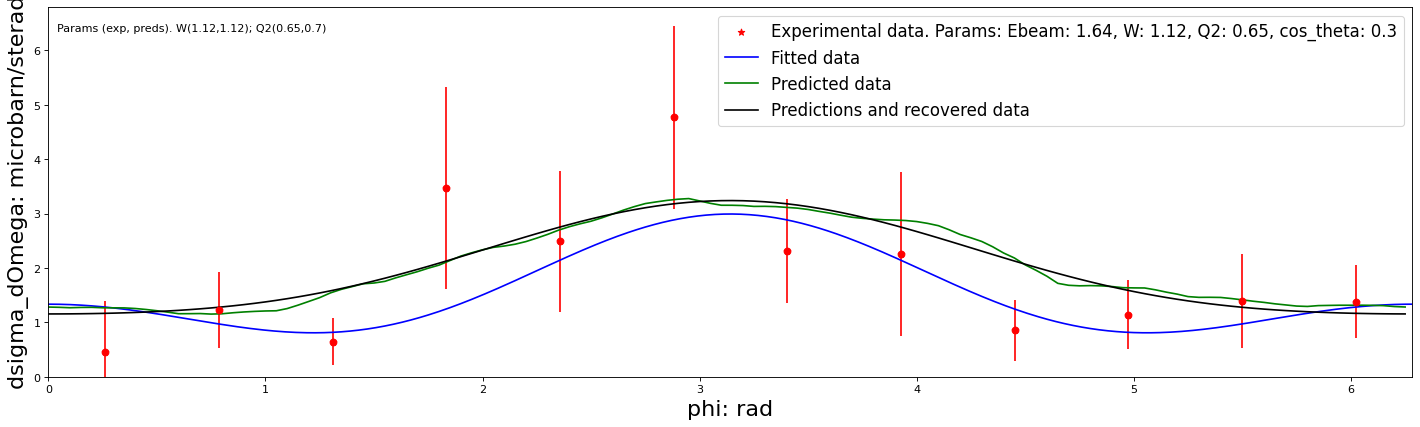

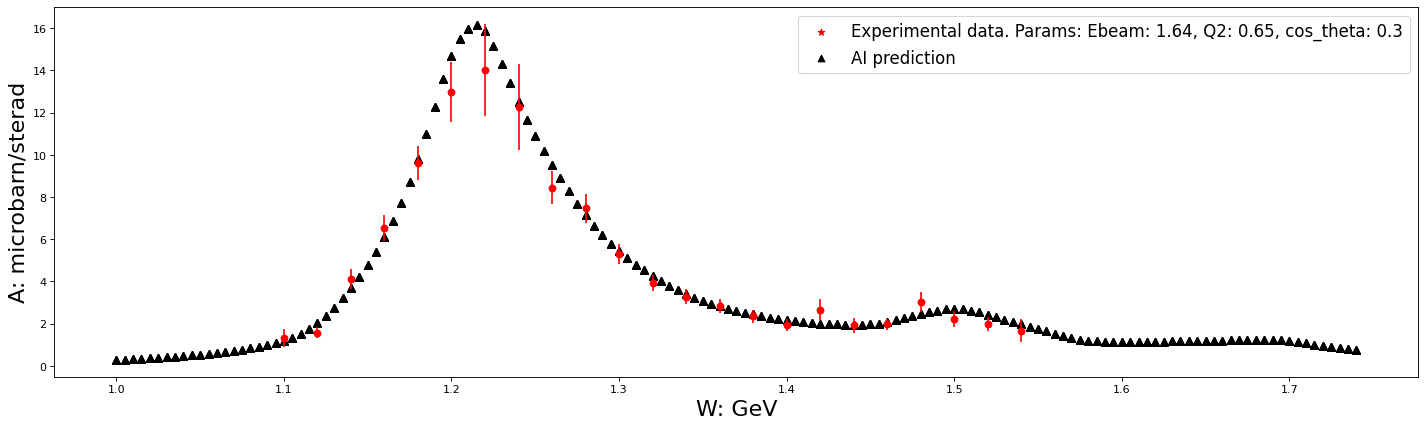

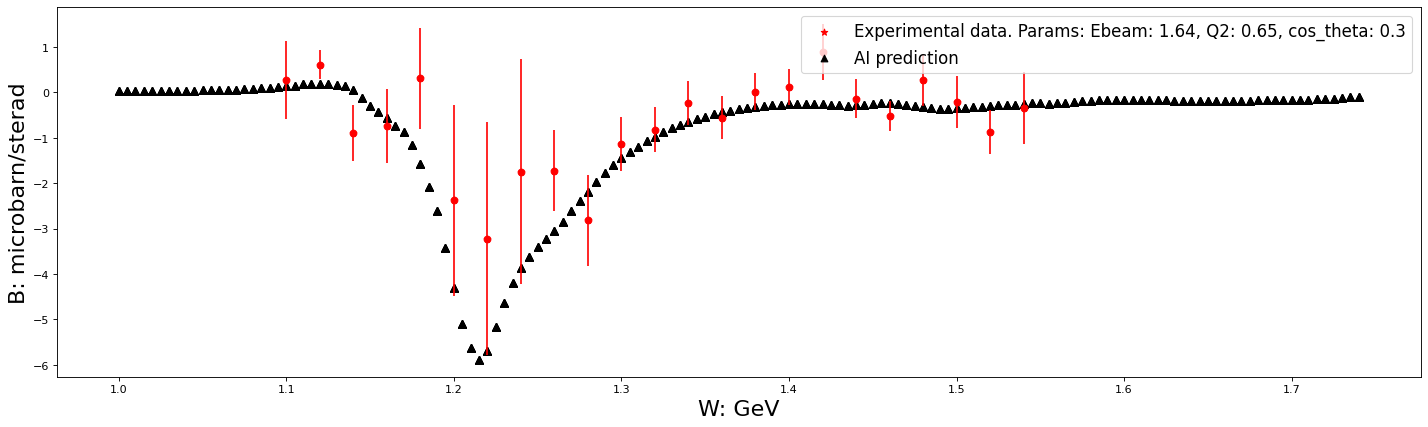

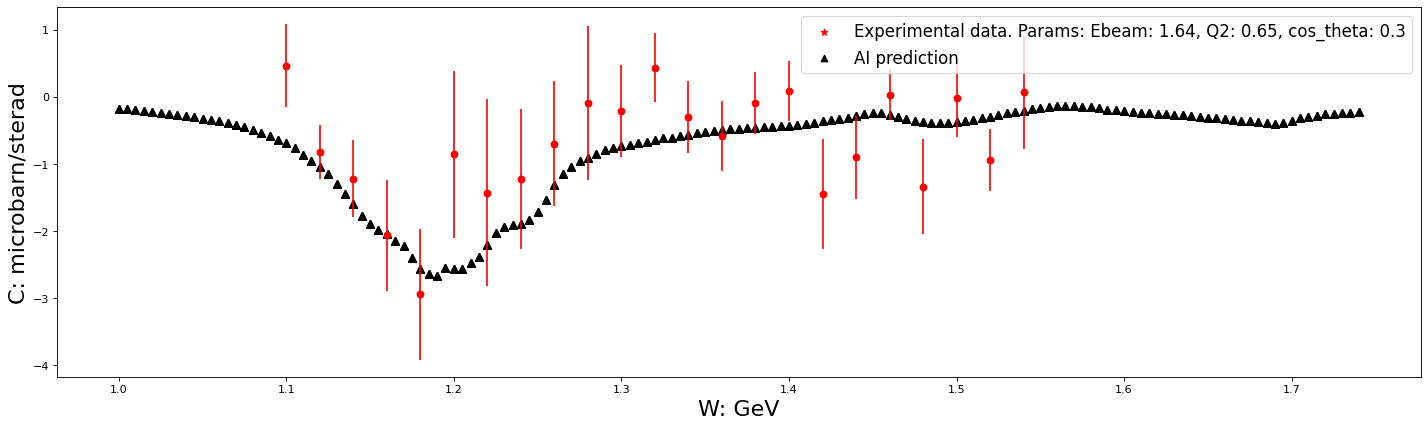

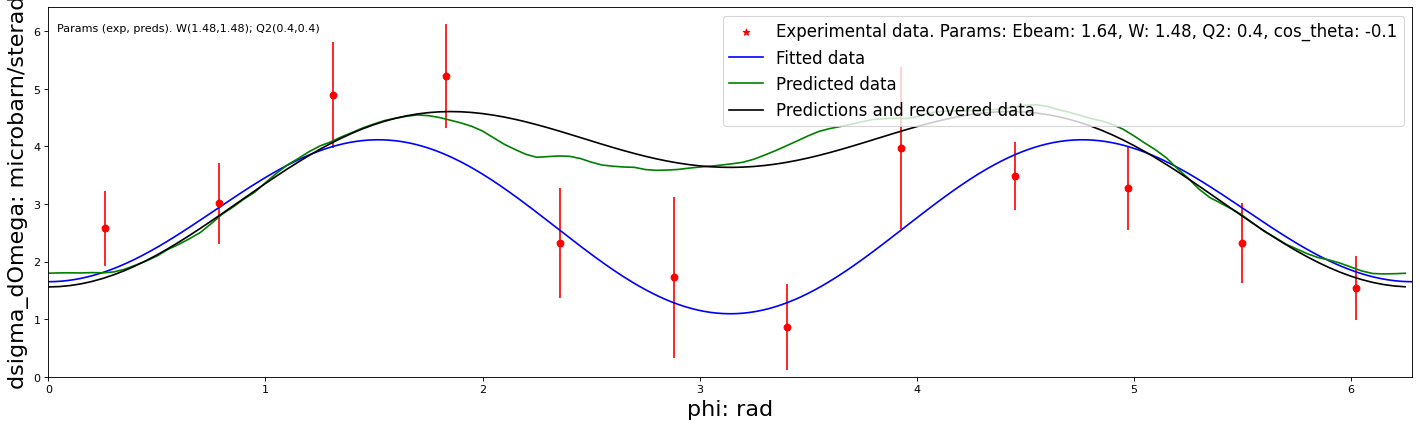

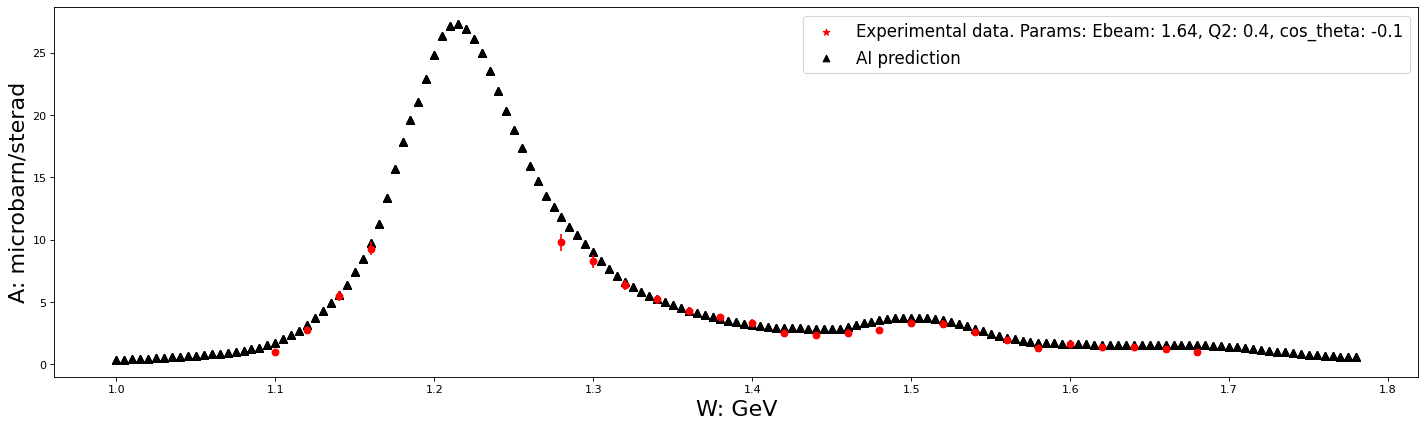

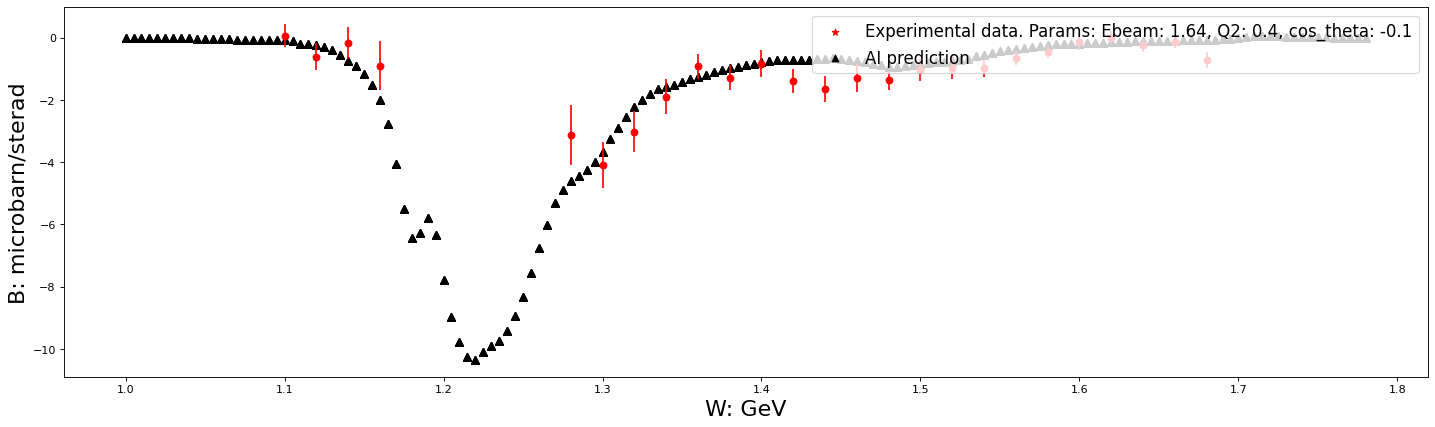

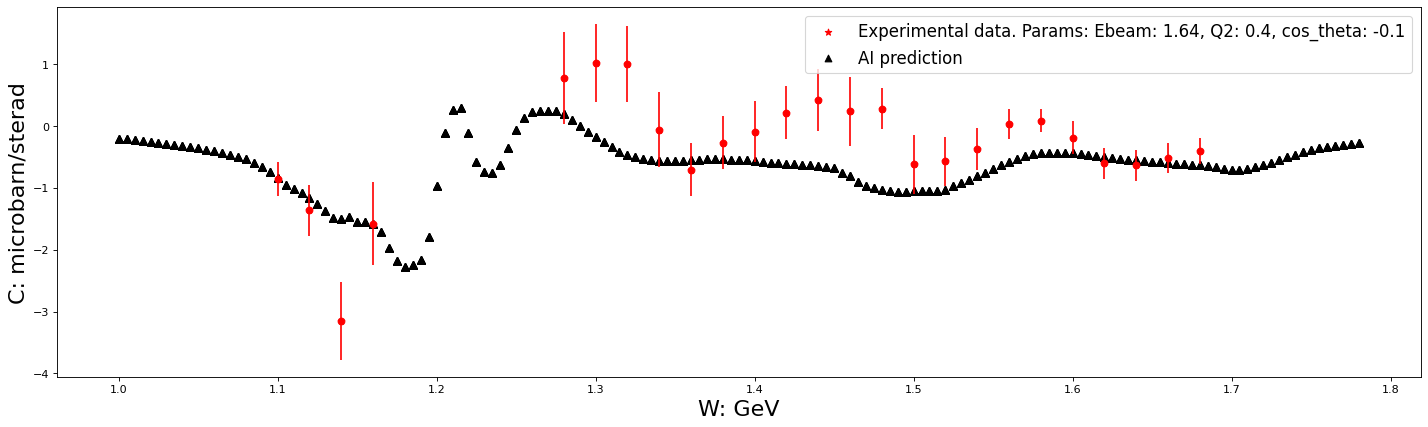

100%|██████████| 157/157 [00:10<00:00, 15.63it/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-17-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.10538976197505366' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-17-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.003527693008122997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-in

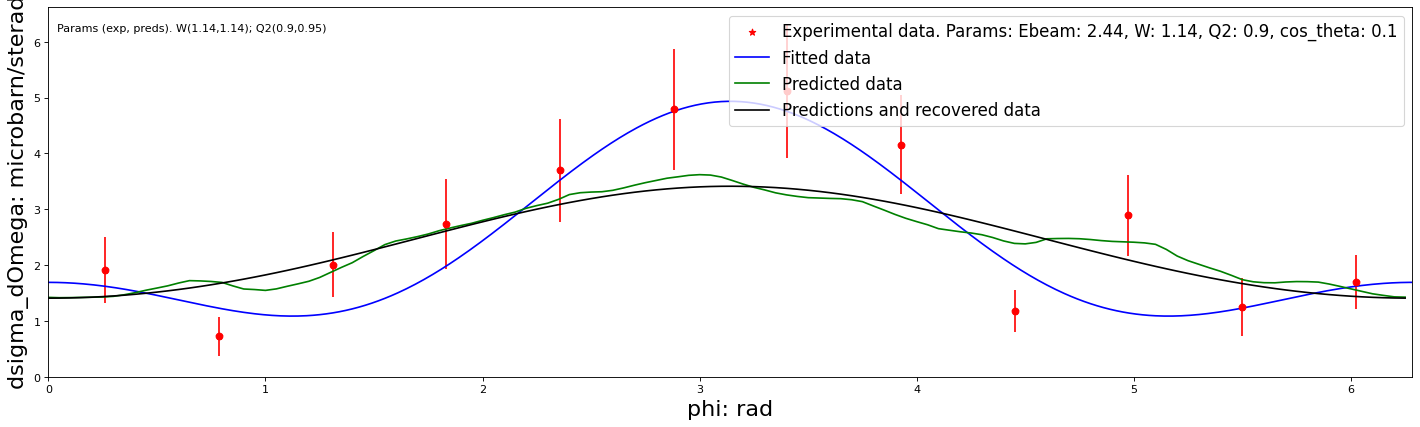

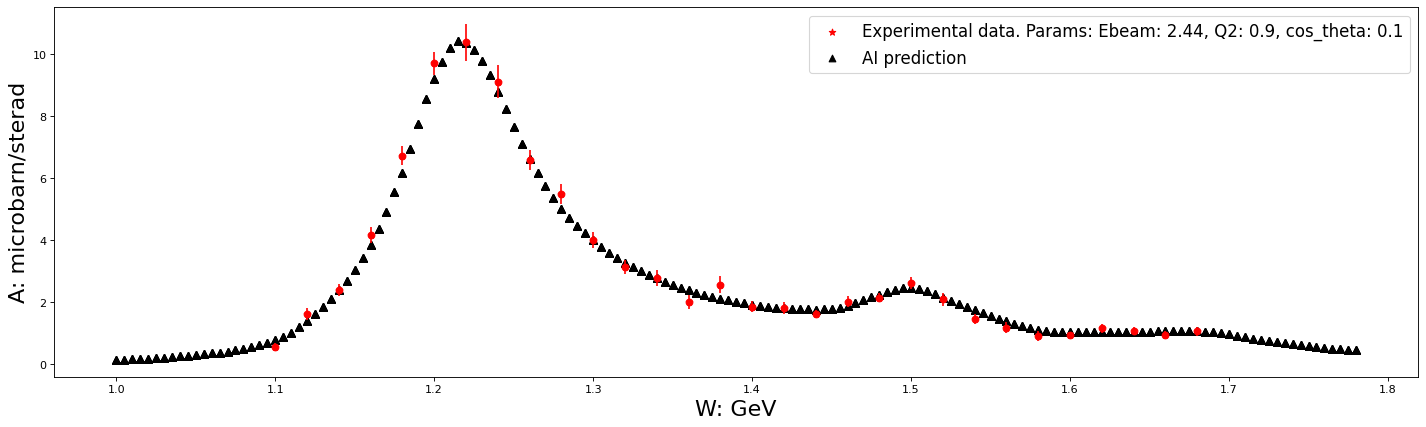

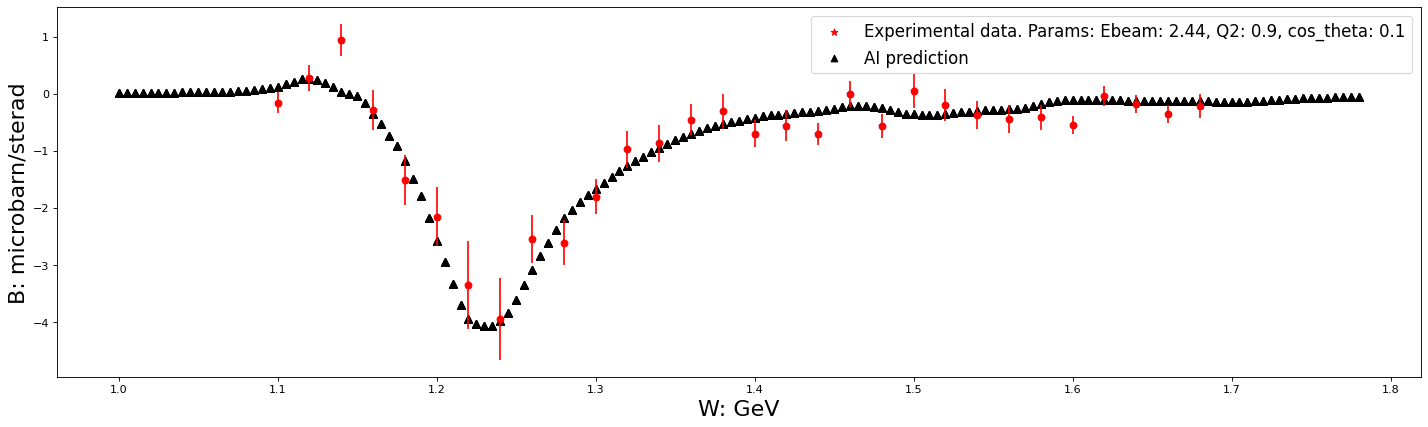

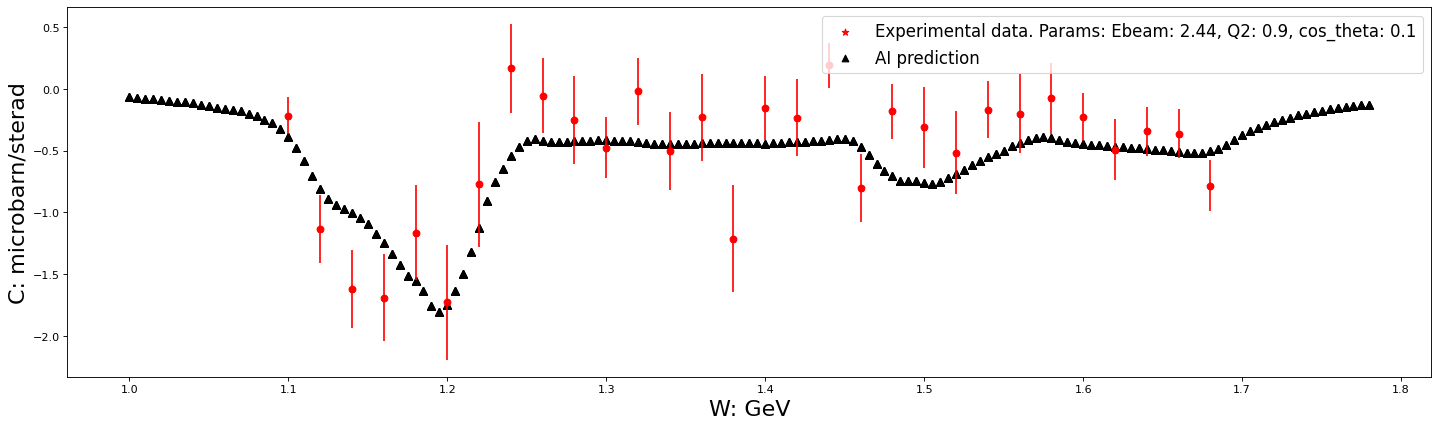

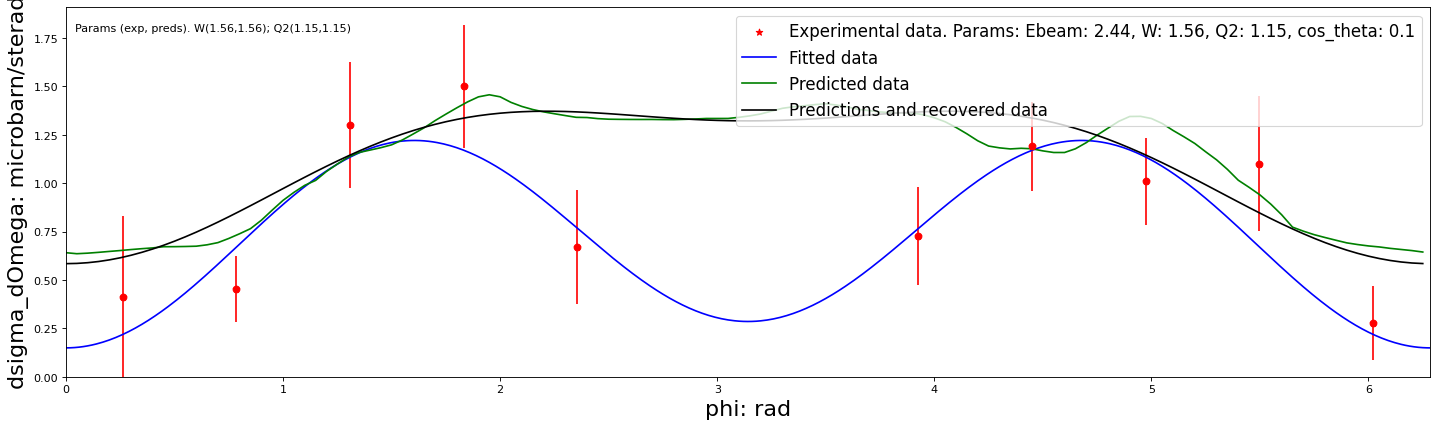

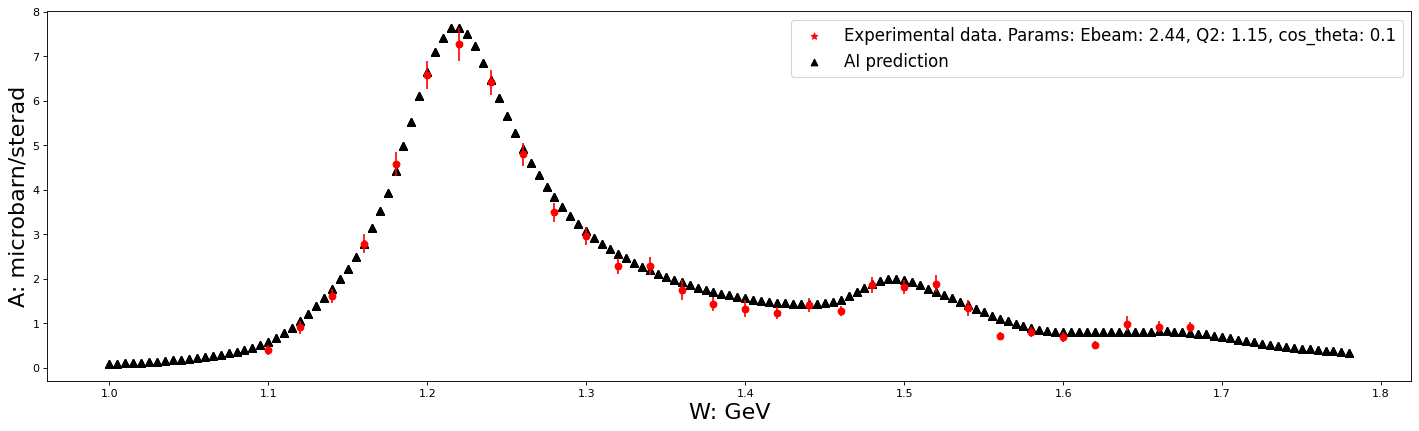

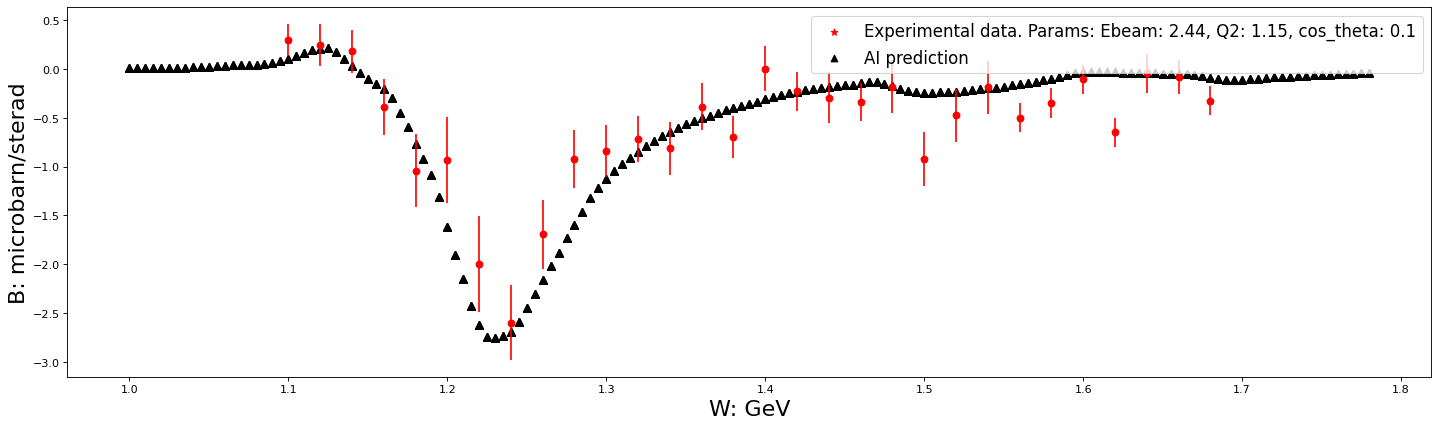

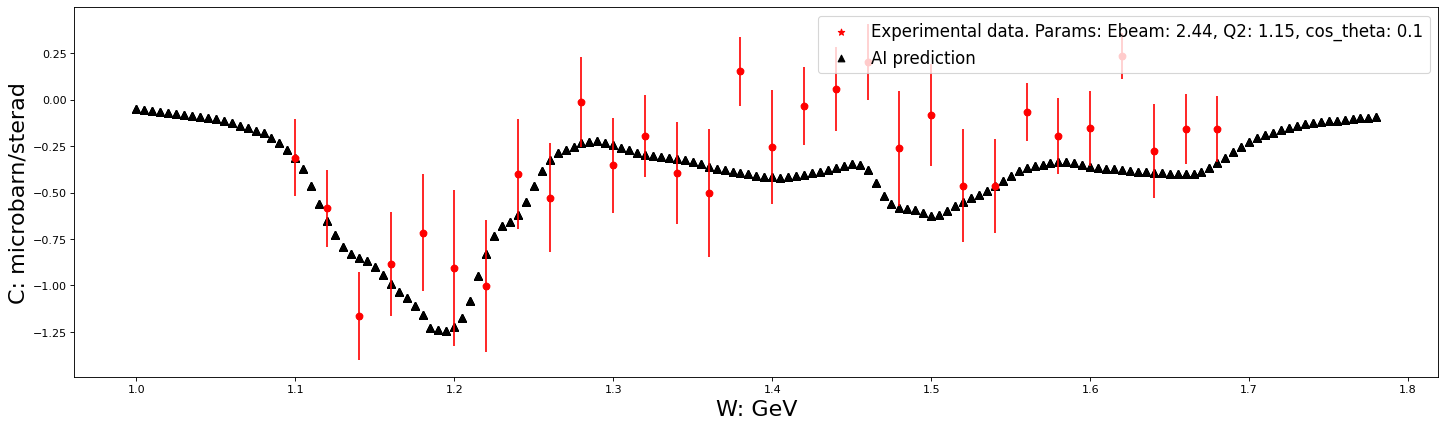

100%|██████████| 97/97 [00:14<00:00,  6.67it/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/67221 [00:00<?, ?it/s]<ipython-input-17-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0313866497132865' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-17-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0009394397113001242' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-inp

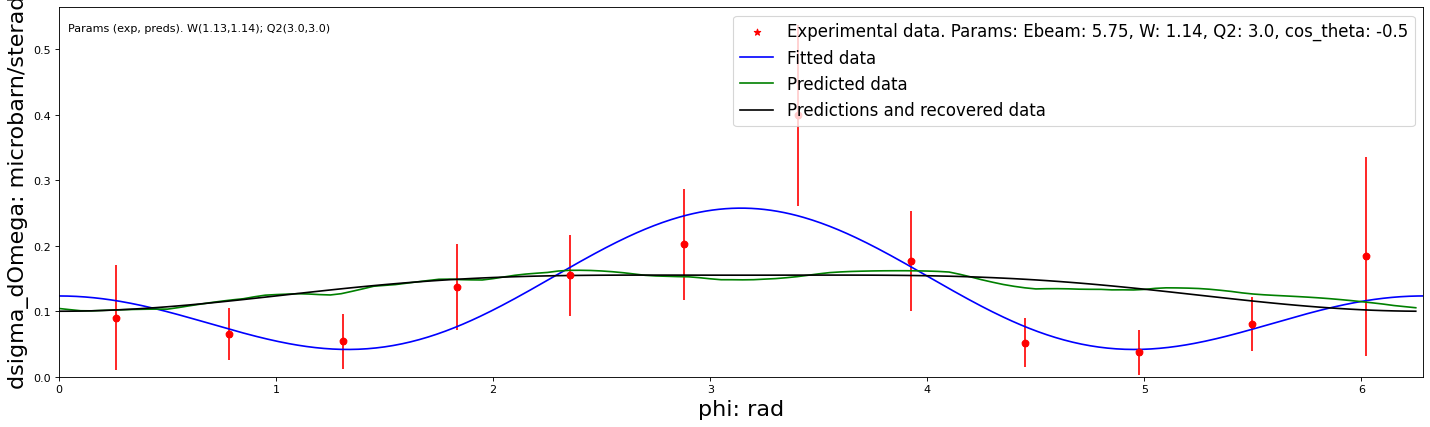

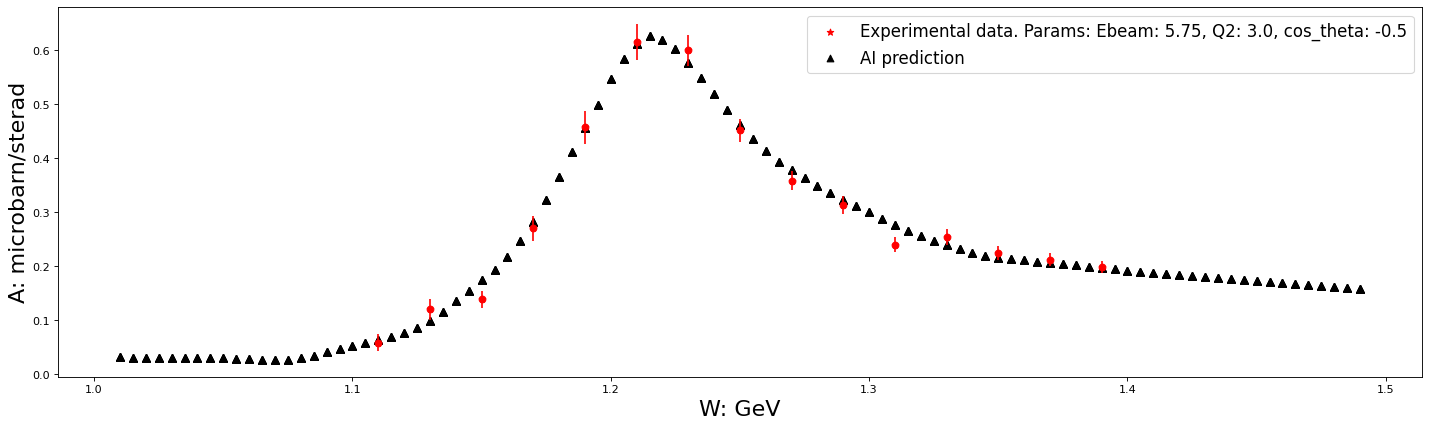

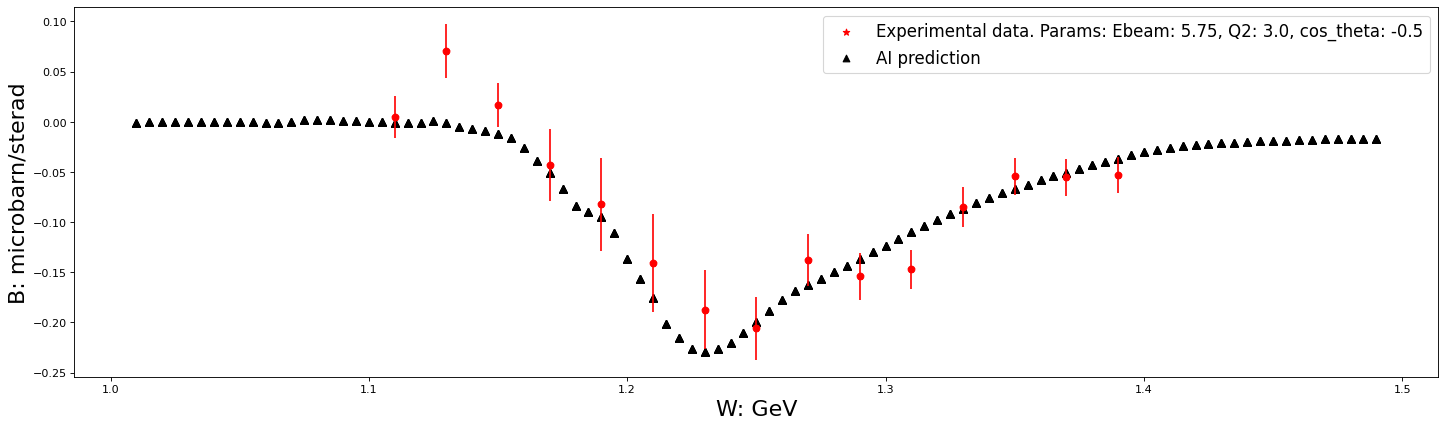

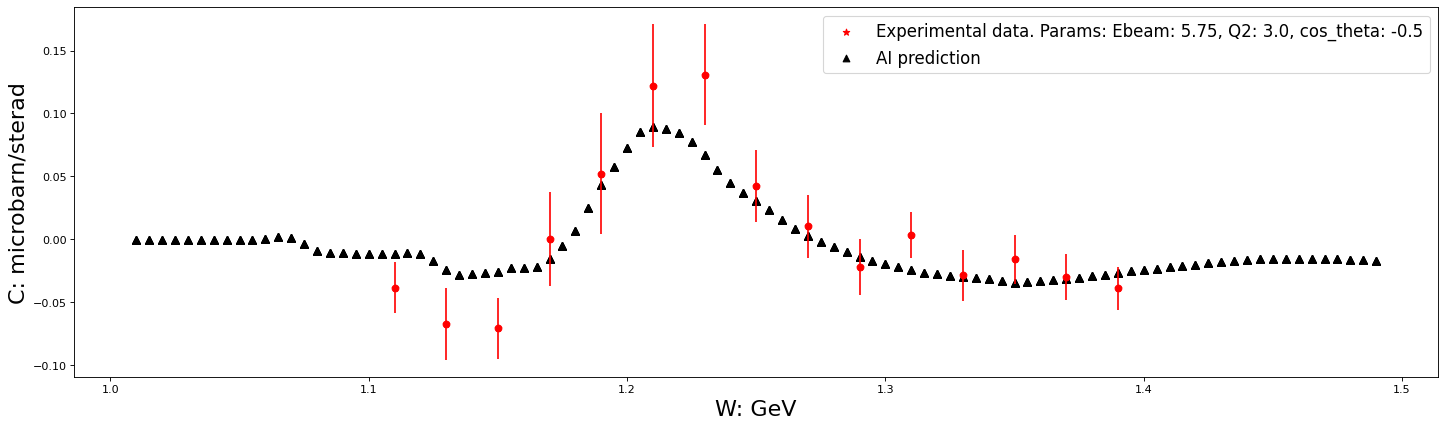

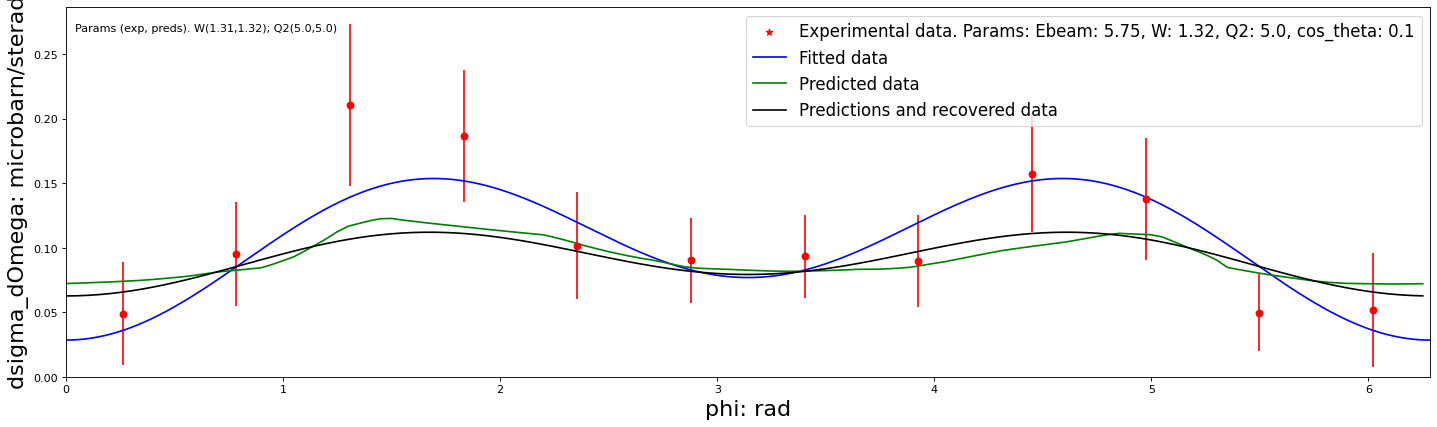

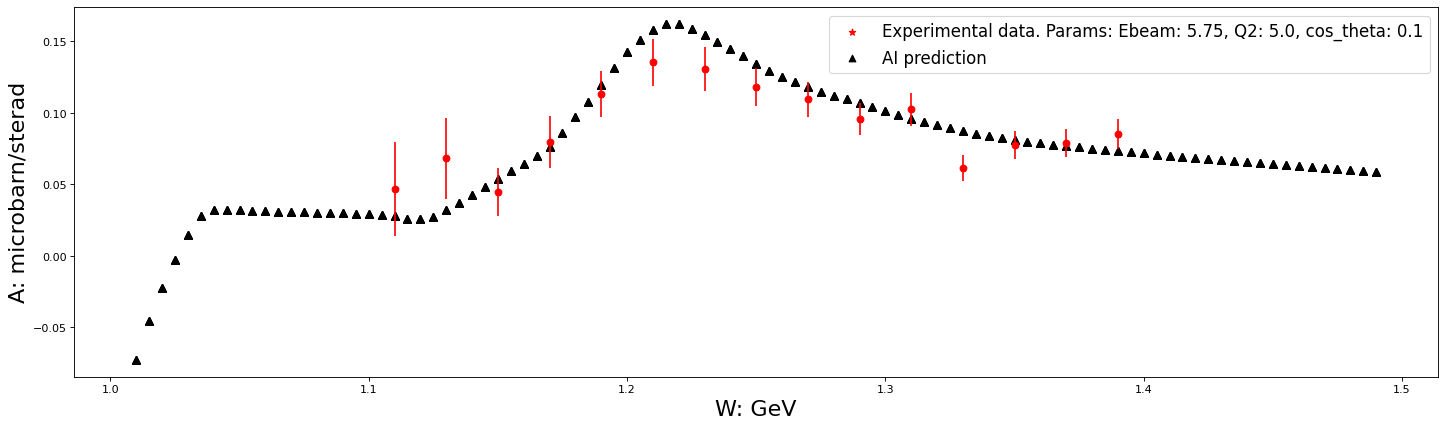

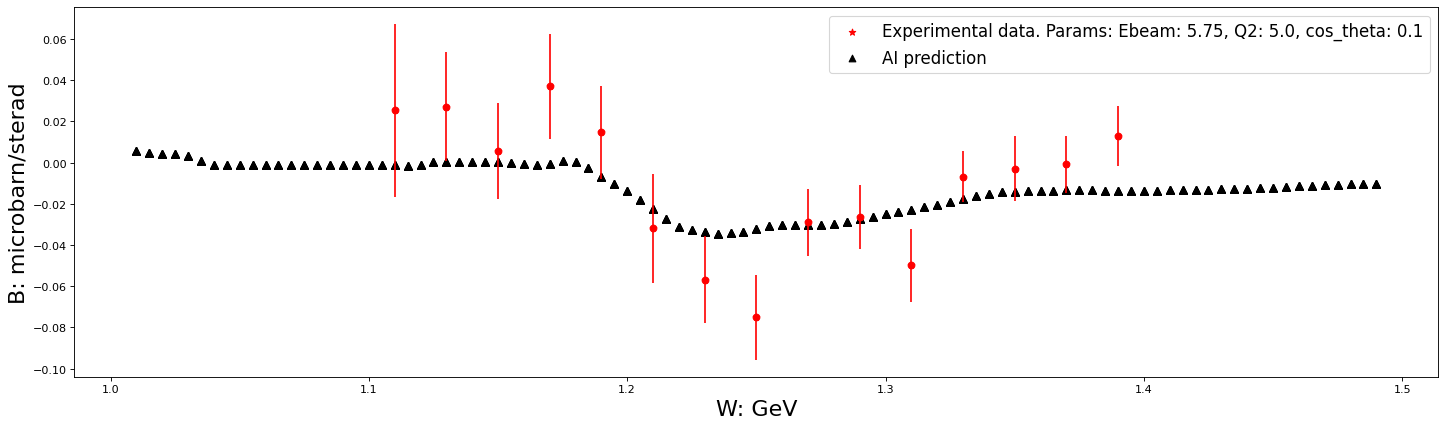

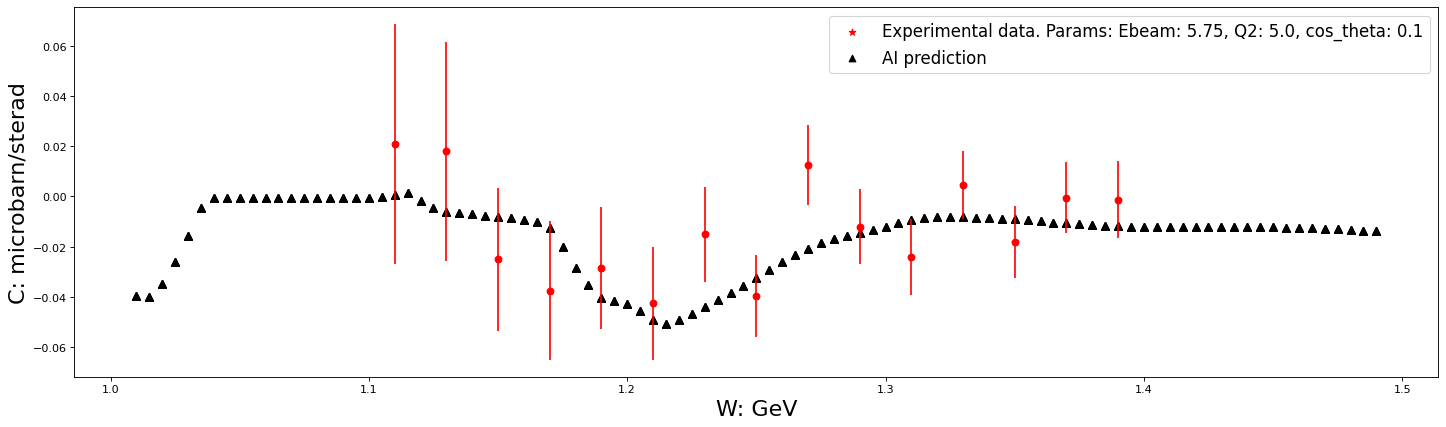

100%|██████████| 177/177 [00:08<00:00, 20.95it/s]
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  0%|          | 0/33453 [00:00<?, ?it/s]<ipython-input-17-3a0b5e42a48b>:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.13589270378941362' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-17-3a0b5e42a48b>:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0033465508199310634' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-

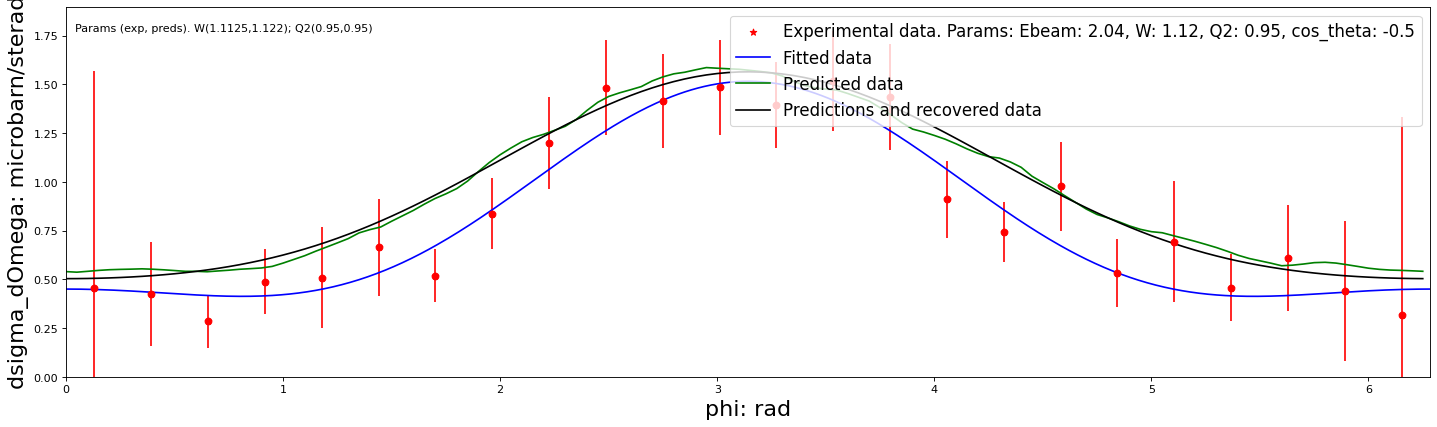

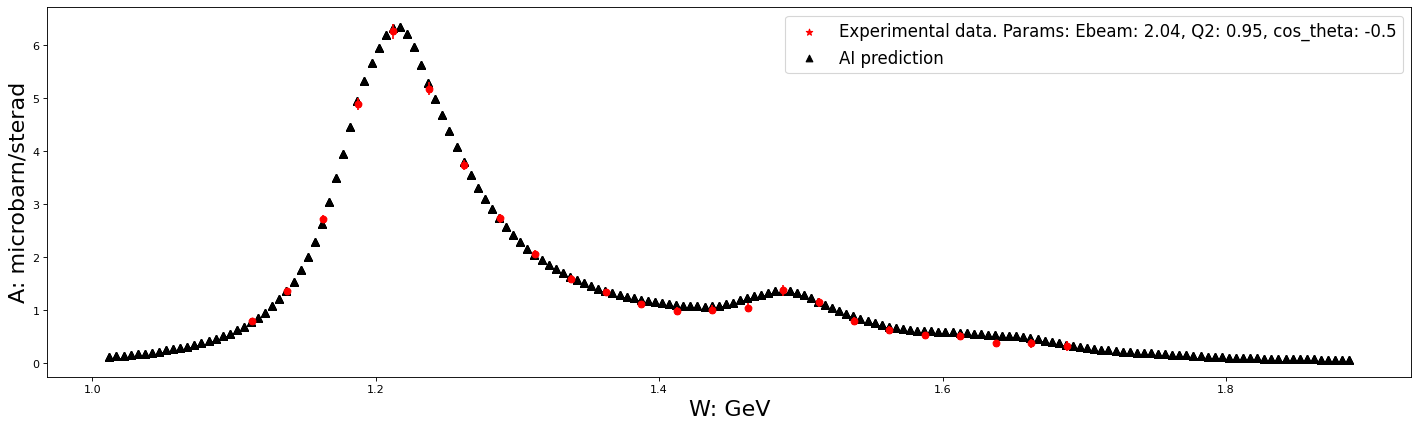

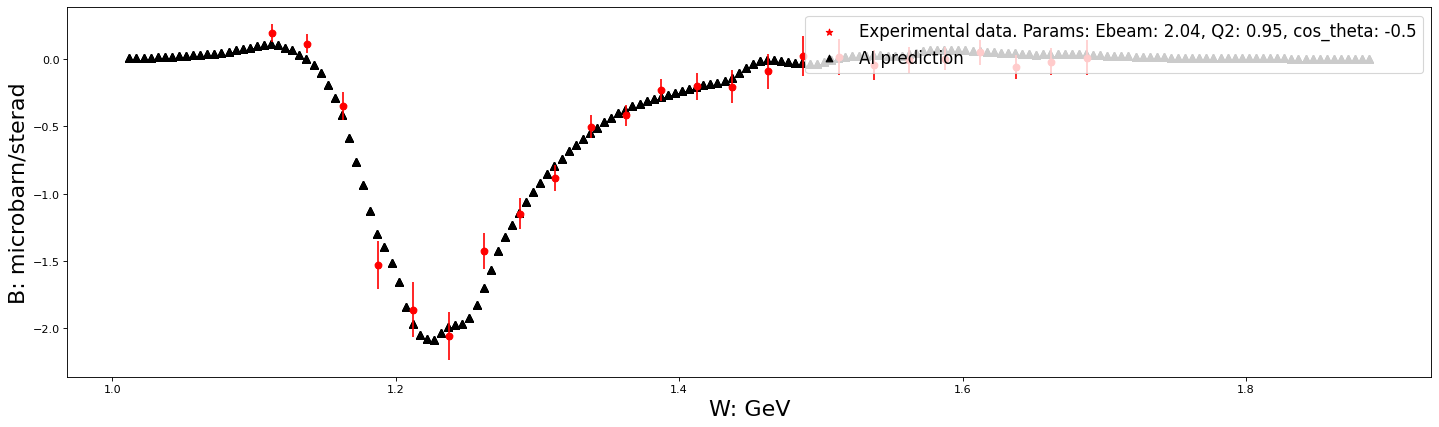

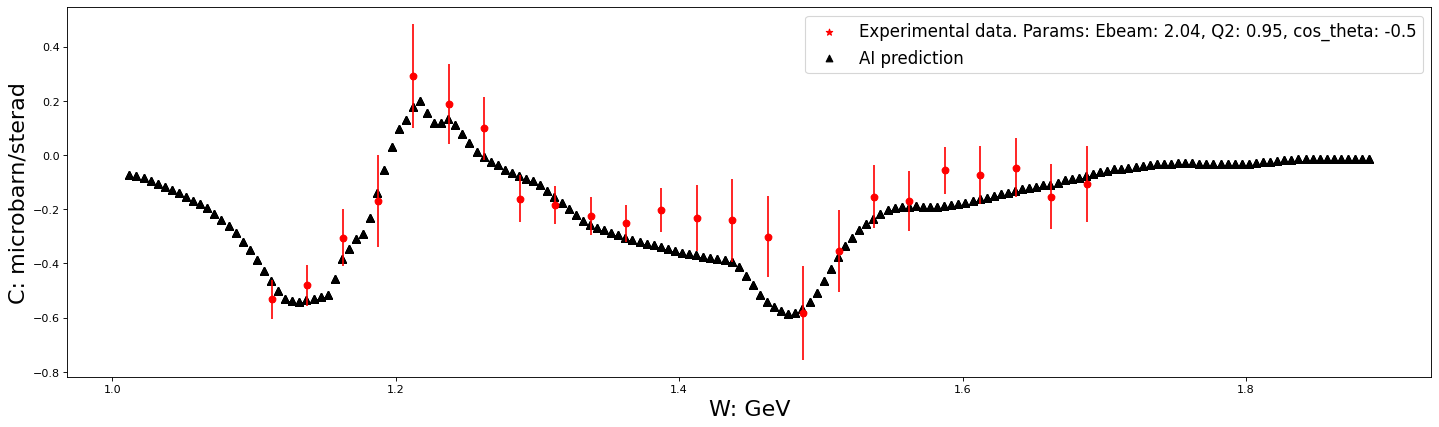

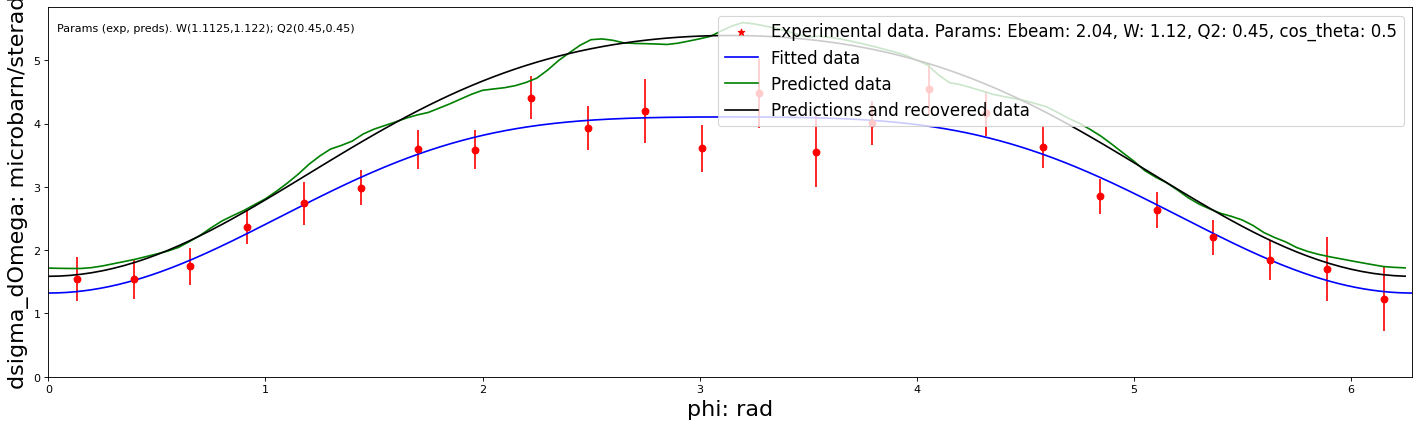

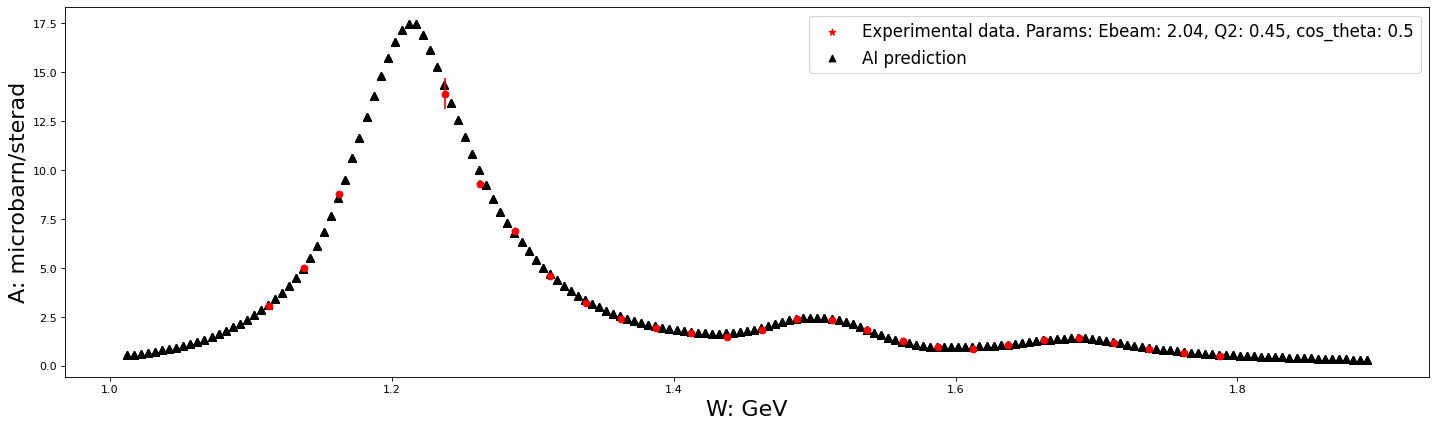

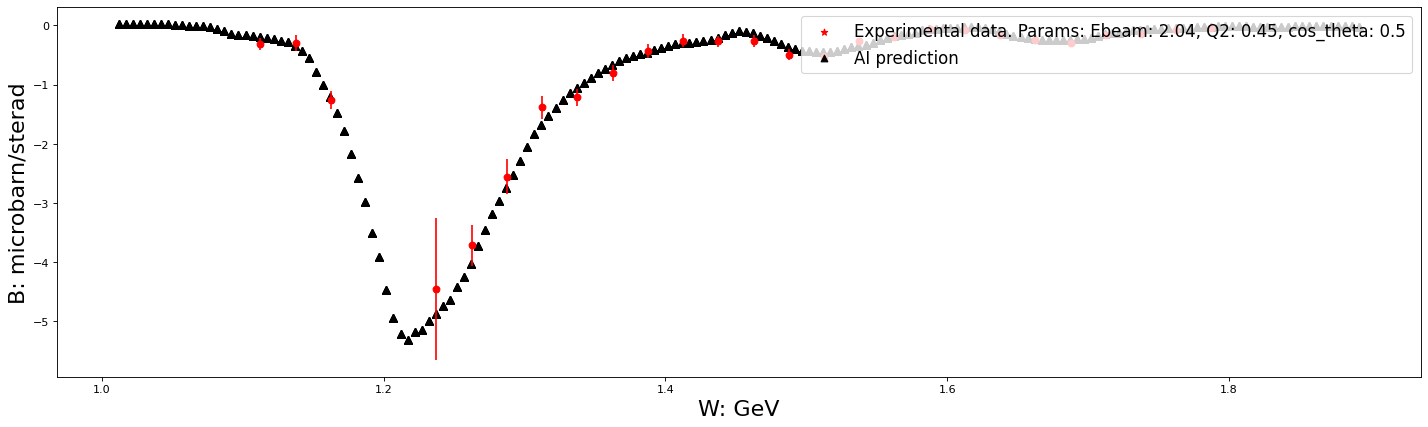

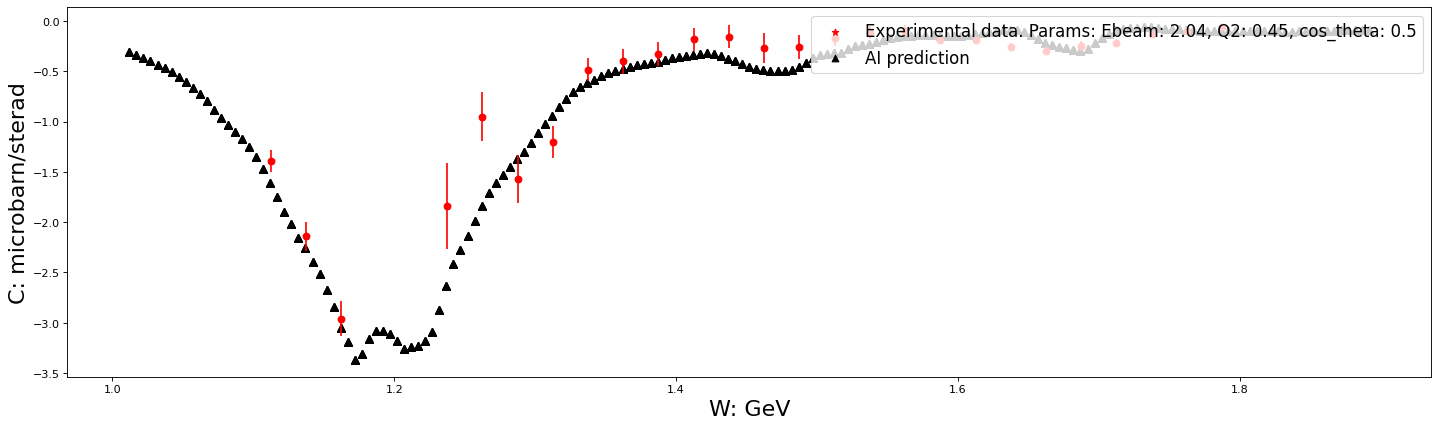

In [19]:
def plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf):
    plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
    return None

for Ebeam in [1.64, 2.44, 5.75, 2.04]:
    os.makedirs(f"/content/NN/E_beam={Ebeam}", exist_ok=True)
    df_grid = generate_grid_df(Ebeam)
    df_sf = generate_df_sf(Ebeam)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[0]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[0]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[0]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[1]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[1]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[1]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

In [20]:
# Log results to W&B Media

# for root, dirs, files in os.walk(os.path.abspath("/content/NN")):
#     for file in files:
#         path_to_img = os.path.join(root, file)
#         im = plt.imread(path_to_img)
#         wandb.log({"img": [wandb.Image(path_to_img)]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})

2025-02-19 00:41:49,272 : DEBUG : STREAM b'IHDR' 16 13
2025-02-19 00:41:49,279 : DEBUG : STREAM b'tEXt' 41 58
2025-02-19 00:41:49,283 : DEBUG : STREAM b'pHYs' 111 9
2025-02-19 00:41:49,290 : DEBUG : STREAM b'IDAT' 132 65536
2025-02-19 00:41:49,336 : DEBUG : Starting new HTTPS connection (1): api.wandb.ai:443
2025-02-19 00:41:49,408 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None
2025-02-19 00:41:49,467 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/1.1" 200 None
2025-02-19 00:41:49,493 : DEBUG : STREAM b'IHDR' 16 13
2025-02-19 00:41:49,497 : DEBUG : STREAM b'tEXt' 41 58
2025-02-19 00:41:49,500 : DEBUG : STREAM b'pHYs' 111 9
2025-02-19 00:41:49,503 : DEBUG : STREAM b'IDAT' 132 65536
2025-02-19 00:41:49,538 : DEBUG : STREAM b'IHDR' 16 13
2025-02-19 00:41:49,541 : DEBUG : STREAM b'tEXt' 41 58
2025-02-19 00:41:49,546 : DEBUG : STREAM b'pHYs' 111 9
2025-02-19 00:41:49,551 : DEBUG : STREAM b'IDAT' 132 38171
2025-02-19 00:41:49,582 : DEBUG : STREAM b'IHDR' 16 13
2

In [21]:
# Log results to W&B Artifacts

wandb_table = wandb.Table(columns=["Ebeam", "cross section","A","B","C"])


for root, dirs, files in os.walk(os.path.abspath("/content/NN//E_beam=1.64")):
    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'))

    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.04")):
    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'))

    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.44")):
    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'))

    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=5.75")):
    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'))

    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'))



# Create a wandb Artifact
artifact = wandb.Artifact(name="plots", type="data")
# Add the table to the artifact
#artifact.add(wandb.Image(path_to_img), "plots_E_beam={Ebeam}")
artifact.add(wandb_table, f"plots")
# Log the artifact
wandb.log_artifact(artifact)

2025-02-19 00:41:52,497 : DEBUG : STREAM b'IHDR' 16 13
2025-02-19 00:41:52,498 : DEBUG : STREAM b'tEXt' 41 58
2025-02-19 00:41:52,503 : DEBUG : STREAM b'pHYs' 111 9
2025-02-19 00:41:52,505 : DEBUG : STREAM b'IDAT' 132 65536
2025-02-19 00:41:52,533 : DEBUG : STREAM b'IHDR' 16 13
2025-02-19 00:41:52,535 : DEBUG : STREAM b'tEXt' 41 58
2025-02-19 00:41:52,536 : DEBUG : STREAM b'pHYs' 111 9
2025-02-19 00:41:52,540 : DEBUG : STREAM b'IDAT' 132 38171
2025-02-19 00:41:52,564 : DEBUG : STREAM b'IHDR' 16 13
2025-02-19 00:41:52,566 : DEBUG : STREAM b'tEXt' 41 58
2025-02-19 00:41:52,571 : DEBUG : STREAM b'pHYs' 111 9
2025-02-19 00:41:52,573 : DEBUG : STREAM b'IDAT' 132 36954
2025-02-19 00:41:52,613 : DEBUG : STREAM b'IHDR' 16 13
2025-02-19 00:41:52,615 : DEBUG : STREAM b'tEXt' 41 58
2025-02-19 00:41:52,623 : DEBUG : STREAM b'pHYs' 111 9
2025-02-19 00:41:52,629 : DEBUG : STREAM b'IDAT' 132 36280
2025-02-19 00:41:52,682 : DEBUG : STREAM b'IHDR' 16 13
2025-02-19 00:41:52,687 : DEBUG : STREAM b'tEXt' 

<Artifact plots>

In [22]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr_scheduler_monitoring,█████▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▇██████████████████████████████████████
train_rmse,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
# #for random choice cross sections and structure functions
# os.makedirs(f"/content/NN/cross_sections", exist_ok=True)
# os.makedirs(f"/content/NN/structure_functions", exist_ok=True)
# for Ebeam in [1.64, 2.44, 5.75, 2.04]:
#     df_grid = generate_grid_df(Ebeam)
#     df_sf = generate_df_sf(Ebeam)
#     step = 0
#     while step != 2:
#         picture_is_not_drawn = True
#         while picture_is_not_drawn:
#             Q2 = random.choice(df[df.Ebeam==Ebeam].Q2.unique())
#             W = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2)].W.unique())
#             cos_theta = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2) & (df.W==W)].cos_theta.unique())
#             try:
#                 plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
#             except:
#                 print(Ebeam, W, Q2, cos_theta)
#             else:
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
#                 step += 1
#                 picture_is_not_drawn = False